In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
current_folder = globals()['_dh'][0] 
rel_path = "Cases"
file_path = os.path.join(current_folder, rel_path)
file_path

'c:\\Users\\kandemir\\Desktop\\DataSurgeryCaseStudy\\Cases'

In [78]:
image_size = (560, 360)
batch_size = 32
#Creating image dataframes and splitting test and train data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    file_path,
    validation_split=0.25,
    labels='inferred',
    subset="training",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
    smart_resize=False,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    file_path,
    validation_split=0.25,
    labels='inferred',
    subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
    smart_resize=False,
)
# Labels generated according to the directory order
# bening 0 maling 1

Found 76 files belonging to 2 classes.
Using 57 files for training.
Found 76 files belonging to 2 classes.
Using 19 files for validation.


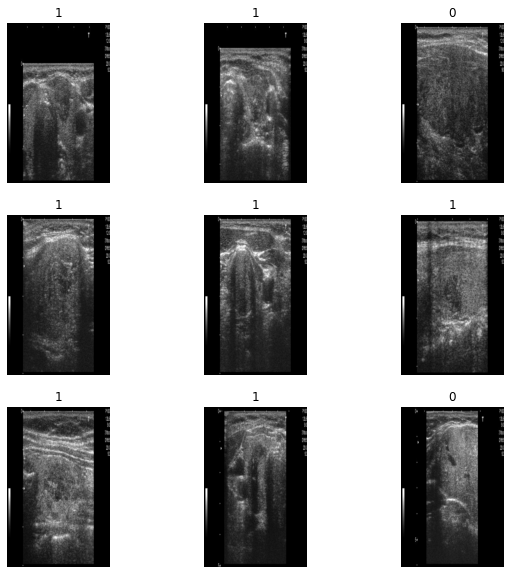

In [69]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# Dataset was not large so artifically increasing diversity is usefull
# Here images are rotated and flipped to increase variety
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

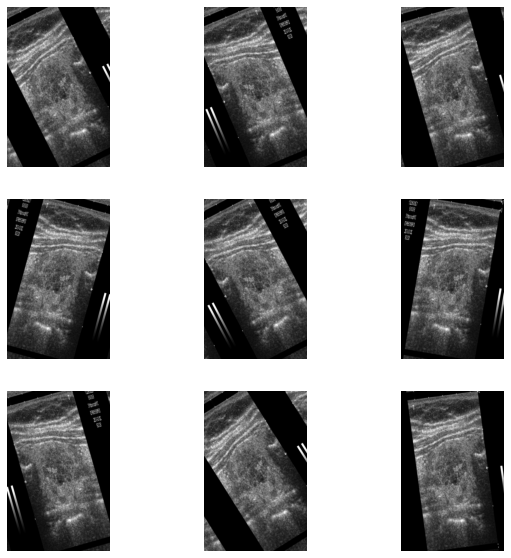

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [48]:
# Data augmentation is added to the dataset
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [50]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

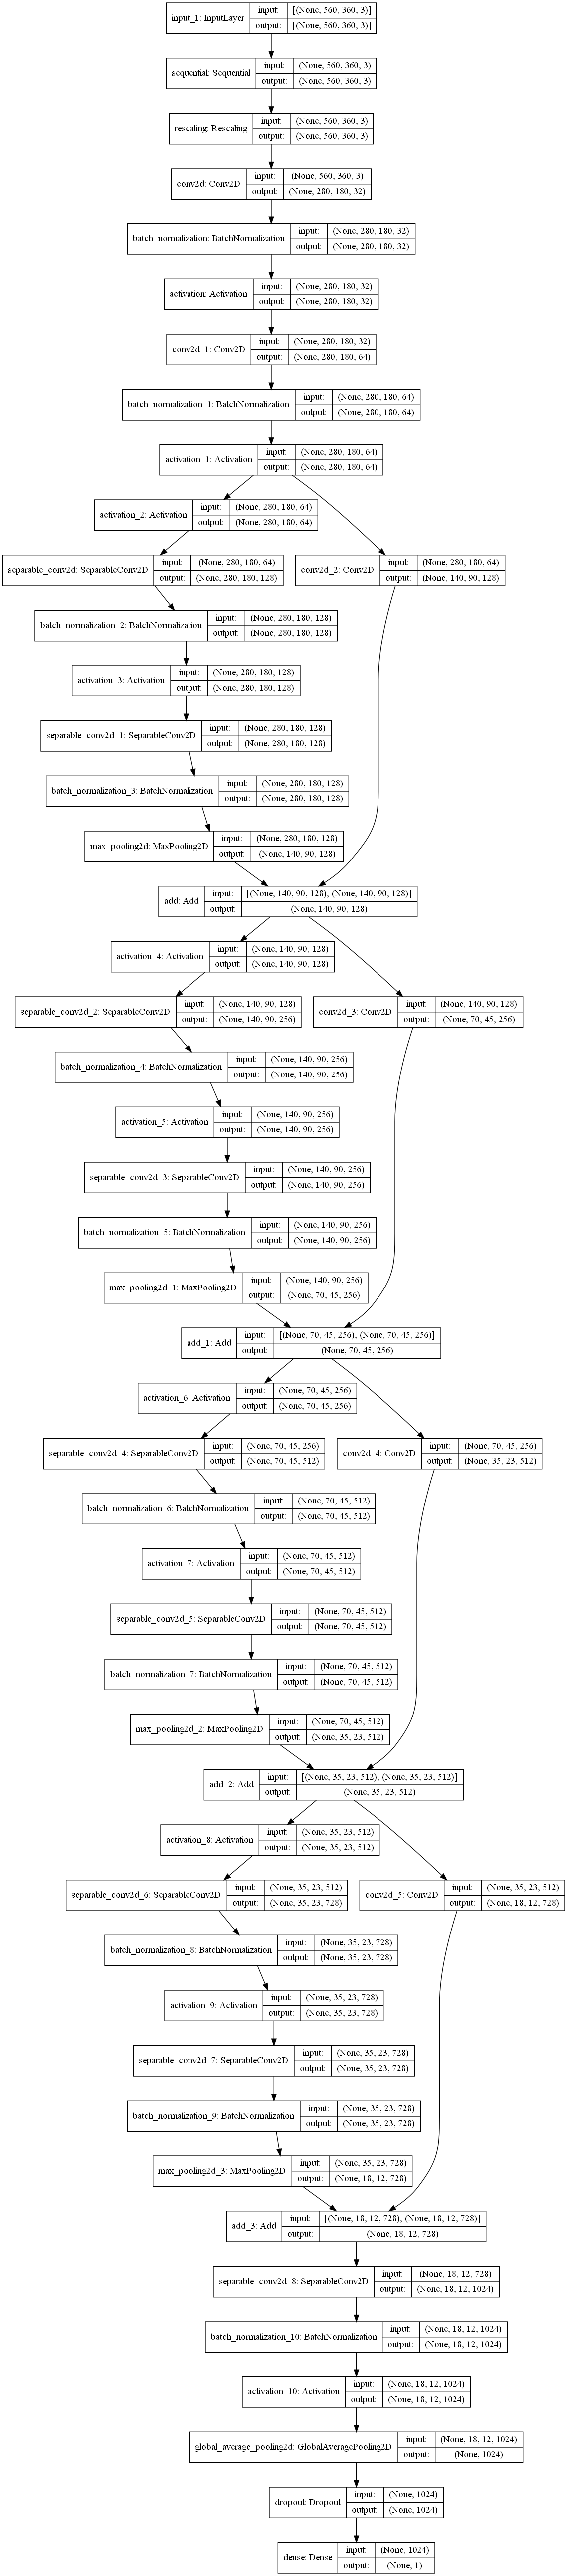

In [9]:
# Making the model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [11]:
# Callback to stop after accuracy reaches %90
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 9e-1:
            self.model.stop_training = True

In [14]:
# Model training
epochs = 30
#callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),  CustomCallback]
callbacks = [CustomCallback()]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
    tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
    
history = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/30
2/2 [==============================] - 36s 16s/step - loss: 0.7502 - accuracy: 0.5000 - true_positives_2: 21.0000 - true_negatives_2: 6.0000 - false_positives_2: 6.0000 - false_negatives_2: 21.0000 - val_loss: 0.6788 - val_accuracy: 0.9091 - val_true_positives_2: 20.0000 - val_true_negatives_2: 0.0000e+00 - val_false_positives_2: 2.0000 - val_false_negatives_2: 0.0000e+00
Epoch 2/30
2/2 [==============================] - 33s 15s/step - loss: 0.5252 - accuracy: 0.8148 - true_positives_2: 41.0000 - true_negatives_2: 3.0000 - false_positives_2: 9.0000 - false_negatives_2: 1.0000 - val_loss: 0.6686 - val_accuracy: 0.9091 - val_true_positives_2: 20.0000 - val_true_negatives_2: 0.0000e+00 - val_false_positives_2: 2.0000 - val_false_negatives_2: 0.0000e+00
Epoch 3/30
2/2 [==============================] - 33s 15s/step - loss: 0.5110 - accuracy: 0.7963 - true_positives_2: 42.0000 - true_negatives_2: 1.0000 - false_positives_2: 11.0000 - false_negatives_2: 0.0000e+00 - val_loss: 0.66

dict_keys(['loss', 'accuracy', 'true_positives_2', 'true_negatives_2', 'false_positives_2', 'false_negatives_2', 'val_loss', 'val_accuracy', 'val_true_positives_2', 'val_true_negatives_2', 'val_false_positives_2', 'val_false_negatives_2'])


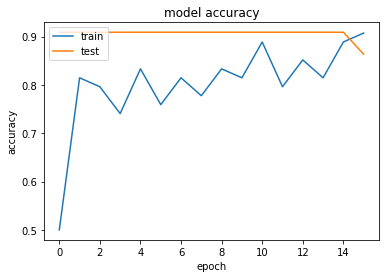

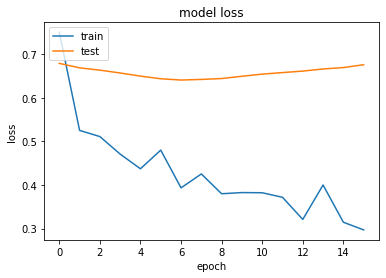

In [15]:
# Graph for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Graph for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
# Summary of True positive and False positive rates
import pandas as pd
roc_df = pd.DataFrame(columns=["TP","FP","TN","FN","TPR","FPR"])
roc_df["TP"] = history.history["true_positives_2"]
roc_df["FP"] = history.history["false_positives_2"]
roc_df["TN"] = history.history["true_negatives_2"]
roc_df["FN"] = history.history["false_negatives_2"]
roc_df["TPR"] = roc_df["TP"]/(roc_df["TP"]+roc_df["FN"])
roc_df["FPR"] = roc_df["FP"]/(roc_df["FP"]+roc_df["TN"])
roc_df.agg({
    "TP": ["mean","median","min","max"],
    "FP": ["mean","median","min","max"],
    "TN": ["mean","median","min","max"],
    "FN": ["mean","median","min","max"],
    "TPR": ["mean","median","min","max"],
    "FPR": ["mean","median","min","max"]
})

,TP,FP,TN,FN,TPR,FPR
mean,39.0,7.6875,4.3125,3.0,0.928571,0.640625
median,40.0,8.0000,4.0000,2.0,0.952381,0.666667
min,21.0,4.0000,0.0000,0.0,0.500000,0.333333
max,42.0,12.0000,8.0000,21.0,1.000000,1.000000


1/1 [==============================] - 3s 3s/step


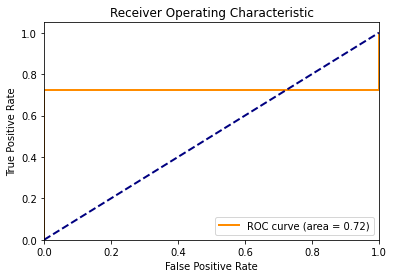

In [79]:
# ROC Curve 
model.evaluate(val_ds)
preds = model.predict(val_ds, verbose=1)

# To get true binary labels of BatchDataset
y = np.concatenate([y for x, y in val_ds], axis=0) 

fpr, tpr, _ = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Due to the low number of data in dataset ROC is meaningless
# If test dataset data amount will be increased accuracy will fall

In [65]:
img = keras.preprocessing.image.load_img(
    "test.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent bening and %.2f percent malign."
    % (100 * (1 - score), 100 * score)
)

This image is 46.88 percent bening and 53.12 percent malign.
